In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from collections import Counter

from joblib import Parallel, delayed
from tqdm.notebook import tqdm
import dill
import pandas as pd
import polars as pl
import numpy as np
from scipy.sparse import csr_matrix

import lightfm

In [3]:
from otto_utils import *

In [4]:
df_test = pl.read_parquet(TEST_PROCESSED, use_pyarrow=True)

In [5]:
df_test.groupby("type").count()

type,count
i64,u32
0,6292632
2,65480
1,570011


# Explore how many items from all session are in ground truth

In [ ]:
# load
val_df_train = pl.read_parquet(VALIDATION_PATH / "train.parquet", use_pyarrow=True)
val_df_valid_input = pl.read_parquet(VALIDATION_PATH / "valid.parquet", use_pyarrow=True)
val_df_valid_targets = pl.read_parquet(VALIDATION_PATH / "test_labels.parquet", use_pyarrow=True)

# First baseline

## polars

In [ ]:
def generate_pairs(df):
    df = df.sort(["session", "ts"])
    df = df.with_column(pl.col("aid").shift(-1).alias("aid_next"))
    df = df.with_column(pl.concat_str([pl.col("session"), pl.lit("_"), pl.col("dt")]).alias("session_day"))
    vc = df['session_day'].value_counts().rename({"counts": "session_day_count"})
    df = df.join(vc, on="session_day")
    df = df.with_columns([pl.col("ts").rank().over('session_day').alias("ranking")])
    df = df.filter(pl.col("session_day_count") != pl.col("ranking"))

    sim_aids = (
        df.groupby("aid").agg([pl.list("aid_next")])
        .with_column(pl.col("aid_next").apply(lambda l: Counter(l).most_common(50)))
    )
    sim_aids = dict(zip(sim_aids["aid"].to_list(), sim_aids["aid_next"].to_list()))
    sim_aids = {aid: Counter(dict(top)) for aid, top in sim_aids.items()}
    return sim_aids

In [ ]:
def recommend(aids, popular_items, sim_aids):
    
    if len(aids) >= 20:
        return aids[-20:]

    aids = set(aids)
    new_aids = Counter()
    for aid in aids:
        new_aids.update(sim_aids.get(aid, Counter()))
    
    top_aids2 = [aid2 for aid2, cnt in new_aids.most_common(40) if aid2 not in aids] 
    final_rec_list = list(aids) + top_aids2[:20 - len(aids)]
    
    if len(final_rec_list) < 20:
        return final_rec_list + popular_items[:20-len(final_rec_list)]
    else:
        return final_rec_list

### validation

In [4]:
# load
val_df_train = pl.read_parquet(VALIDATION_PATH / "train.parquet", use_pyarrow=True)
val_df_valid_input = pl.read_parquet(VALIDATION_PATH / "valid.parquet", use_pyarrow=True)
val_df_valid_targets = pl.read_parquet(VALIDATION_PATH / "test_labels.parquet", use_pyarrow=True)

In [41]:
val_df_train = (
    val_df_train
    .with_columns([
        pl.col("ts").cast(pl.Datetime(time_unit="ms", time_zone="Etc/GMT-2")).alias("dt")
    ])
    .with_columns([
        pl.col("dt").cast(pl.Date)
    ])
)

val_df_valid_input = (
    val_df_valid_input
    .with_columns([
        pl.col("ts").cast(pl.Datetime(time_unit="ms", time_zone="Etc/GMT-2")).alias("dt")
    ])
    .with_columns([
        pl.col("dt").cast(pl.Date)
    ])
)

In [220]:
sim_aids = generate_pairs(val_df_train)

In [222]:
test_df = val_df_valid_input.sort(["session", "type", "ts"])
test_session_dict = test_df.groupby('session').agg(pl.list("aid"))
test_session_dict = dict(zip(test_session_dict["session"].to_list(), test_session_dict["aid"].to_list()))
popular_items = val_df_train['aid'].value_counts(sort=True)["aid"].to_list()

submission_dict = {
    "session_type": [],
    "labels": [],
}

types = ["clicks", "carts", "orders"]
topk = 20


for session_id, session_item_list in tqdm(test_session_dict.items()):
    rec_items = recommend(session_item_list, popular_items, sim_aids)
    
    session_types = [f"{session_id}_{t}" for t in types]
    labels = " ".join(str(aid) for aid in rec_items)
    labels_list = [labels] * 3
    
    submission_dict["session_type"].extend(session_types)
    submission_dict["labels"].extend(labels_list)

100%|██████████| 1303355/1303355 [00:50<00:00, 25651.30it/s]


In [223]:
df_submission = pl.DataFrame(submission_dict)

In [224]:
calc_valid_score(df_submission)

/app/notebooks/otto/otto_utils.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_labels["ground_truth"].loc[labels_null_idx] = (


validation score: 0.5422151127466824
recall per type: type
carts     0.378347
clicks    0.502955
orders    0.630693
dtype: float64


In [130]:
calc_valid_score(df_submission)

/app/notebooks/otto/otto_utils.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_labels["ground_truth"].loc[labels_null_idx] = (


validation score: 0.49612517618847596
recall per type: type
carts     0.325173
clicks    0.396398
orders    0.598222
dtype: float64


### submission

In [228]:
df_train = pl.read_parquet(TRAIN_PROCESSED, use_pyarrow=True)
df_test = pl.read_parquet(TEST_PROCESSED, use_pyarrow=True)

In [229]:
df_train = (
    df_train
    .with_columns([
        pl.col("ts").cast(pl.Datetime(time_unit="ms", time_zone="Etc/GMT-2")).alias("dt")
    ])
    .with_columns([
        pl.col("dt").cast(pl.Date)
    ])
)

df_test = (
    df_test
    .with_columns([
        pl.col("ts").cast(pl.Datetime(time_unit="ms", time_zone="Etc/GMT-2")).alias("dt")
    ])
    .with_columns([
        pl.col("dt").cast(pl.Date)
    ])
)

In [232]:
sim_aids = generate_pairs(df_train)

In [233]:
test_df = df_test.sort(["session", "type", "ts"])
test_session_dict = test_df.groupby('session').agg(pl.list("aid"))
test_session_dict = dict(zip(test_session_dict["session"].to_list(), test_session_dict["aid"].to_list()))
popular_items = df_train['aid'].value_counts(sort=True)["aid"].to_list()

submission_dict = {
    "session_type": [],
    "labels": [],
}

types = ["clicks", "carts", "orders"]
topk = 20


for session_id, session_item_list in tqdm(test_session_dict.items()):
    rec_items = recommend(session_item_list, popular_items, sim_aids)
    
    session_types = [f"{session_id}_{t}" for t in types]
    labels = " ".join(str(aid) for aid in rec_items)
    labels_list = [labels] * 3
    
    submission_dict["session_type"].extend(session_types)
    submission_dict["labels"].extend(labels_list)

100%|██████████| 1671803/1671803 [00:58<00:00, 28593.02it/s]


In [235]:
df_submission = pl.DataFrame(submission_dict)

In [236]:
df_submission.write_csv("baseline_submission.csv")

## pandas (from kaggle notebook) - check correctness

In [134]:
import os
import pandas as pd

from datetime import datetime
from tqdm import tqdm

from collections import defaultdict
import math
import numpy as np
import random
import copy
from collections import Counter

In [195]:
train_df = pd.read_parquet(VALIDATION_PATH / "train.parquet")
test_df = pd.read_parquet(VALIDATION_PATH / "valid.parquet")
sample_sub_df = pd.read_csv(DATA_FOLDER / "sample_submission.csv")

In [136]:
train_df['aid'] = train_df['aid'].astype('int32').astype('str')
test_df['aid'] = test_df['aid'].astype('int32').astype('str')

In [196]:
train_df['time_stamp'] = pd.to_datetime(train_df['ts'] / 1000, unit='s').dt.strftime('%Y-%m-%d')
test_df['time_stamp'] = pd.to_datetime(test_df['ts'] / 1000, unit='s').dt.strftime('%Y-%m-%d')

In [147]:
train_df

,session,aid,ts,type,time_stamp
0,0,1517085,1659304800025,0,2022-07-31
1,0,1563459,1659304904511,0,2022-07-31
2,0,1309446,1659367439426,0,2022-08-01
3,0,16246,1659367719997,0,2022-08-01
4,0,1781822,1659367871344,0,2022-08-01
...,...,...,...,...,...
164253450,11107738,1156708,1661126394861,0,2022-08-21
164253451,11107739,841799,1661126396245,0,2022-08-21
164253452,11107740,544144,1661126397005,0,2022-08-21
164253453,11107741,1757555,1661126397425,0,2022-08-21


In [139]:
def generate_pairs(df):
    df = df.sort_values(by=['session','ts'])
    df['aid_next'] = df['aid'].shift(-1)
    df['session_day'] = df['session'].astype('str')+'_'+df['time_stamp']
    df['session_day_count'] = df['session_day'].map(df['session_day'].value_counts())
    df['ranking'] = df.groupby(['session_day'])['ts'].rank(method='first', ascending=True)
    df = df.query('session_day_count!=ranking').reset_index(drop=True)
    
    sim_aids = df.groupby('aid').apply(lambda df: Counter(df.aid_next).most_common(50)).to_dict()
    sim_aids = {aid: Counter(dict(top)) for aid, top in sim_aids.items()}
    return sim_aids

In [141]:
def recommend(aids,popular_items):
    
    if len(aids) >= 20:
        return aids[-20:]

    aids = set(aids)
    new_aids = Counter()
    for aid in aids:
        new_aids.update(sim_aids.get(aid, Counter()))
    
    top_aids2 = [aid2 for aid2, cnt in new_aids.most_common(40) if aid2 not in aids] 
    final_rec_list = list(aids) + top_aids2[:20 - len(aids)]
    
    if len(final_rec_list)<20:
        return final_rec_list + popular_items[:20-len(final_rec_list)]
    else:
        return final_rec_list

In [ ]:
sim_aids = generate_pairs(train_df)

In [142]:
test_df = test_df.sort_values(["session", "type", "ts"])
test_session_dict = test_df.groupby('session')['aid'].agg(list).to_dict()
session_id_list = []
item_id_list = []

popular_items = list(train_df['aid'].value_counts().index)

for session_id,session_item_list in tqdm(test_session_dict.items()):
    item_list = recommend(session_item_list,popular_items)
    
    session_id_list.append(session_id)
    item_id_list.append(list(item_list))

res_df = pd.DataFrame()
res_df['session_type'] = session_id_list
res_df['labels'] = [' '.join([str(l) for l in lls]) for lls in item_id_list]

100%|██████████| 1303355/1303355 [01:05<00:00, 19950.52it/s]


In [143]:
res_list = []
for type_ in ["clicks", "carts", "orders"]:
    temp_df = copy.deepcopy(res_df)
    temp_df['session_type'] = temp_df['session_type'].apply(lambda x:'{}_{}'.format(x, type_))
    res_list.append(temp_df)
res_df = pd.concat(res_list,axis=0)

In [144]:
df_submission = pl.from_pandas(res_df)

In [145]:
calc_valid_score(df_submission)

/app/notebooks/otto/otto_utils.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_labels["ground_truth"].loc[labels_null_idx] = (


validation score: 0.5421797880403252
recall per type: type
carts     0.378318
clicks    0.503000
orders    0.630641
dtype: float64


# Another base

In [237]:
pip install cudf-cu11 dask-cudf-cu11 --extra-index-url=https://pypi.ngc.nvidia.com
pip install cuml-cu11 --extra-index-url=https://pypi.ngc.nvidia.com
pip install cugraph-cu11 --extra-index-url=https://pypi.ngc.nvidia.com

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.8/442.8 MB 8.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 kB 42.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 MB 33.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 155.7 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 160.6 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 441.3/441.3 kB 111.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 162.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 4.4 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 164.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 135.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 923.4/923.4 kB 135.4 MB/s eta 0:00:00
 

  Attempting uninstall: tornado
    Found existing installation: tornado 6.2
    Uninstalling tornado-6.2:
      Successfully uninstalled tornado-6.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-client 7.4.7 requires tornado>=6.2, but you have tornado 6.1 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 GB 2.9 MB/s eta 0:00:000:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.9/191.9 kB 37.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 580.3/580.3 MB 6.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 864.6/864.6 kB 116.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.5/210.5 MB 17.4 MB/s eta 0:00:0000:0100:01


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 165.1 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 45.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 18.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 GB 3.9 MB/s eta 0:00:000:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 GB 2.5 MB/s eta 0:00:000:00:0100:01


In [5]:
val_df_train

session,aid,ts,type
i64,i64,i64,i64
0,1517085,1659304800025,0
0,1563459,1659304904511,0
0,1309446,1659367439426,0
0,16246,1659367719997,0
0,1781822,1659367871344,0
0,1152674,1659367885796,0
0,1649869,1659369893840,1
0,461689,1659369898050,1
0,305831,1659370027105,2


In [8]:
val_df_train["type"].value_counts()

type,counts
i64,u32
0,147679961
2,3871186
1,12702308


In [10]:
df_aid_sessions = (
    val_df_train
    .groupby(["aid", "type"])
    .agg([
        pl.n_unique("session")
    ])
    .pivot(index="aid", columns="type", values="session")
)

In [12]:
(
    df_aid_sessions
    .filter(pl.col("1").is_not_null())
)

aid,0,2,1
i64,u32,u32,u32
1392100,45,null,3
1077995,36,1,1
1072673,156,1,14
1663577,4,2,3
943108,48,3,4
148994,19,null,1
588546,896,170,445
1283742,10,3,2
1441493,16,3,4


In [13]:
(
    df_aid_sessions
    .filter(pl.col("2").is_not_null())
)

aid,0,2,1
i64,u32,u32,u32
1077995,36,1,1
1072673,156,1,14
1663577,4,2,3
943108,48,3,4
588546,896,170,445
1283742,10,3,2
1441493,16,3,4
802227,126,3,10
1664494,45,1,7


In [29]:
(
    df_aid_sessions
    .select([
        pl.col("0").mean().prefix("mean_"),
        pl.col("0").median().prefix("median_"),
        pl.col("1").mean().prefix("mean_"),
        pl.col("1").median().prefix("median_"),
        pl.col("2").mean().prefix("mean_"),
        pl.col("2").median().prefix("median_"),
    ])
)

mean_0,median_0,mean_1,median_1,mean_2,median_2
f64,f64,f64,f64,f64,f64
55.291664,10.0,9.786735,2.0,6.254524,2.0


In [37]:
val_df_train.filter(pl.col("aid").is_in([490040, 992166, 638866]))

session,aid,ts,type
i64,i64,i64,i64
698166,992166,1659805175960,2
752041,638866,1659367591711,2
2281483,638866,1660590248752,2
2566013,638866,1659535851802,2
3806024,490040,1659726400146,2
4443126,992166,1660121239004,2
4835255,638866,1660984761748,2
5228699,992166,1660070694354,2
5450870,638866,1660981461946,2


In [38]:
val_df_train.filter(pl.col("session") == 2281483)

session,aid,ts,type
i64,i64,i64,i64
2281483,1083413,1659509764744,0
2281483,1083413,1659642413574,0
2281483,1083413,1659695326699,0
2281483,1083413,1659695364994,0
2281483,1083413,1660069922934,0
2281483,1083413,1660069976557,0
2281483,1083413,1660070111271,0
2281483,1714577,1660311445993,0
2281483,1386312,1660590175081,0


In [15]:
val_df_train.filter(pl.col("session") == 3806024)

session,aid,ts,type
i64,i64,i64,i64
3806024,556598,1659682655155,0
3806024,1742863,1659682683253,0
3806024,1742863,1659682753502,0
3806024,556598,1659682765143,0
3806024,1161641,1659682883186,0
3806024,1161641,1659698426095,1
3806024,1161641,1659698432683,1
3806024,1742863,1659698512211,0
3806024,395021,1659725920234,0


In [22]:
val_df_train.filter(pl.col("session") == 698166)

session,aid,ts,type
i64,i64,i64,i64
698166,1204103,1659364384551,0
698166,148619,1659548849598,0
698166,317032,1659548861978,0
698166,1170481,1659710619967,0
698166,573103,1659711219557,0
698166,987926,1659711245357,1
698166,987926,1659805089819,0
698166,992166,1659805175960,2
698166,450695,1659893343902,0


In [ ]:
df = pl.concat([val_df_train, val_df_valid_input])

In [25]:
(
    pl.concat([val_df_train, val_df_valid_input])
    .filter(pl.col("type") == 2)
    .groupby(["session", "aid"])
    .agg([
        pl.n_unique("ts").alias("weight")
    ])
)

session,aid,weight
i64,i64,u32
1371311,1515214,1
8259293,803544,1
989258,702684,1
2767659,859411,1
266464,736573,1
8281850,754646,1
8287314,23058,1
1091873,255152,1
2946435,1652736,1


In [30]:
df = pl.concat([val_df_train, val_df_valid_input])

In [33]:
df_act_w = dataset_action_weights(df)
# df_clicks = dataset_clicks_only(df)

In [35]:
from implicit.nearest_neighbours import CosineRecommender

i2i = CosineRecommender(K=20)
train_data = make_sparse_matrix(df_act_w)
i2i.fit(train_data)

/opt/poetry/virtualenvs/tasks-9TtSrW0h-py3.9/lib/python3.9/site-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.7673377990722656 seconds
  warnings.warn(


  0%|          | 0/1855603 [00:00<?, ?it/s]

In [36]:
i2i.similar_items(743737)

(array([ 743737,  610037, 1171790,  121102, 1209393, 1268183,  462755,
        1211613,  265661, 1396066], dtype=int32),
 array([1.        , 0.39736502, 0.35129191, 0.33151017, 0.28116707,
        0.22263046, 0.21110017, 0.20976905, 0.20479724, 0.19902714]))

In [39]:
val_df_valid_input.groupby("session").agg([pl.count("aid")])

session,aid
i64,u32
11870848,1
12513472,1
12719936,4
11179648,16
11968064,6
12005952,1
12590016,1
11450496,7
11576128,1


In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

In [58]:
session_lengths = val_df_valid_input.groupby("session").agg([pl.count("aid")]).to_pandas()
session_lengths.describe(percentiles=np.arange(0, 1, 0.1))

,session,aid
count,"1,303,355.00","1,303,355.00"
mean,"12,001,279.62",5.09
std,"517,833.29",9.44
min,"11,107,743.00",1.00
0%,"11,107,743.00",1.00
10%,"11,282,978.40",1.00
20%,"11,461,461.60",1.00
30%,"11,644,367.20",1.00
40%,"11,822,103.60",2.00
50%,"12,000,685.00",2.00


In [78]:
df_valid_carts = val_df_valid_targets.filter(pl.col("type") == "carts")
df_valid_orders = val_df_valid_targets.filter(pl.col("type") == "orders")

In [112]:
df_orders_that_were_in_sequence = (
    val_df_valid_input
    .select(["session", "aid"]).unique()
    .join(df_valid_carts.with_column(pl.col("ground_truth").arr.lengths().alias("gt_len")), on="session", how="left")
    .join(df_valid_orders.with_column(pl.col("ground_truth").arr.lengths().alias("gt_len")), on="session", how="left")
    .filter(pl.col("ground_truth").is_not_null() | pl.col("ground_truth_right").is_not_null())
    .with_column(pl.col("aid").is_in(pl.col("ground_truth")).alias("in_carts"))
    .with_column(pl.col("aid").is_in(pl.col("ground_truth_right")).alias("in_orders"))
    .groupby("session")
    .agg([
        pl.n_unique("aid"),
        pl.first("ground_truth").alias("gt_carts"),
        pl.first("gt_len"),
        pl.sum("in_carts"),
        pl.first("ground_truth_right").alias("gt_orders"),
        pl.first("gt_len_right"),
        pl.sum("in_orders"),
    ])
    .with_columns([
        (pl.col("in_carts") / pl.col("gt_len")).alias("in_carts_rate"),
        (pl.col("in_orders") / pl.col("gt_len_right")).alias("in_orders_rate"),
    ])
    .join(val_df_valid_input.groupby("session").agg([pl.count("aid").alias("len")]), on="session")
    .sort("session")
)

In [113]:
df_orders_that_were_in_sequence

session,aid,gt_carts,gt_len,in_carts,gt_orders,gt_len_right,in_orders,in_carts_rate,in_orders_rate,len
i64,u32,list[i64],u32,u32,list[i64],u32,u32,f64,f64,u32
11107744,3,"[165989, 178869, ... 1075085]",4,0,null,null,0,0.0,null,4
11107757,2,[69701],1,1,[69701],1,1,1.0,1.0,2
11107761,21,"[217117, 240567, ... 1835591]",9,7,"[217117, 559821, ... 1566659]",5,4,0.777778,0.8,38
11107765,7,"[57315, 1119263]",2,1,null,null,0,0.5,null,12
11107767,1,[521316],1,1,[521316],1,1,1.0,1.0,3
11107769,1,[812822],1,1,null,null,0,1.0,null,1
11107778,160,"[116772, 742844, ... 1693230]",8,3,null,null,0,0.375,null,308
11107787,1,[166037],1,0,null,null,0,0.0,null,1
11107788,18,"[53600, 102697, ... 1716942]",11,0,"[53600, 220847, ... 1659575]",10,6,0.0,0.6,25


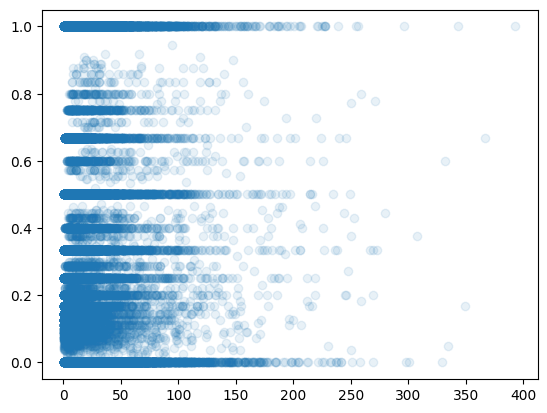

In [114]:
x = df_orders_that_were_in_sequence.filter(pl.col("gt_carts").is_not_null())["len"] 
y = df_orders_that_were_in_sequence.filter(pl.col("gt_carts").is_not_null())["in_carts_rate"]
plt.scatter(x, y, alpha=0.1)

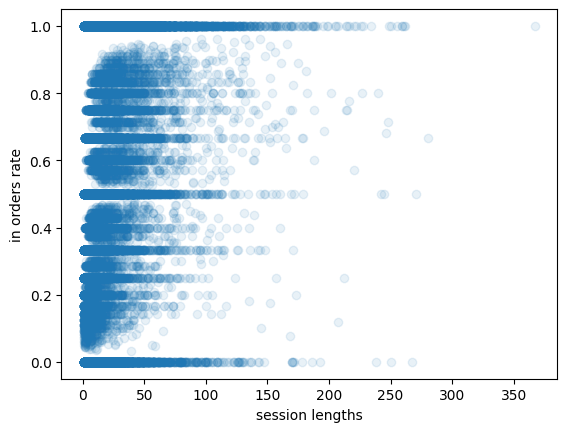

In [115]:
x = df_orders_that_were_in_sequence.filter(pl.col("gt_orders").is_not_null())["len"] 
y = df_orders_that_were_in_sequence.filter(pl.col("gt_orders").is_not_null())["in_orders_rate"]
plt.scatter(x, y, alpha=0.1)
plt.xlabel("session lengths")
plt.ylabel("in orders rate")
plt.show()

In [116]:
df_orders_that_were_in_sequence.filter(pl.col("gt_orders").is_not_null())["in_orders_rate"].mean()

0.6564750492020226

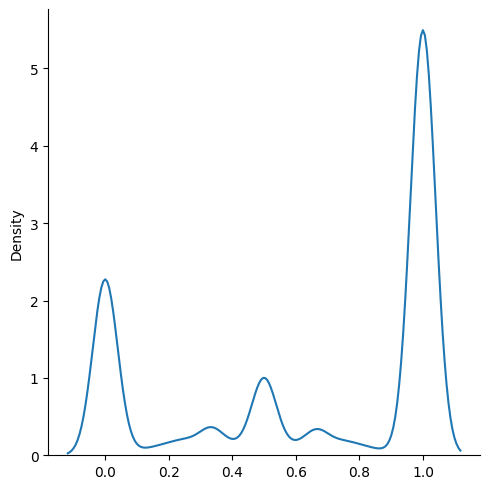

In [117]:
sns.displot(df_orders_that_were_in_sequence["in_orders_rate"], kind="kde")

In [54]:
session_lengths = val_df_train.groupby("session").agg([pl.count("aid").alias("len")]).to_pandas()

In [55]:
session_lengths.describe(percentiles=np.arange(0, 1, 0.1))

,session,aid
count,"11,107,743.00","11,107,743.00"
mean,"5,553,871.00",14.79
std,"3,206,529.35",28.93
min,0.00,1.00
0%,0.00,1.00
10%,"1,110,774.20",2.00
20%,"2,221,548.40",2.00
30%,"3,332,322.60",3.00
40%,"4,443,096.80",4.00
50%,"5,553,871.00",5.00


In [57]:
session_lengths = df_test.groupby("session").agg([pl.count("aid")]).to_pandas()
session_lengths.describe(percentiles=np.arange(0, 1, 0.1))

,session,aid
count,"1,671,803.00","1,671,803.00"
mean,"13,735,680.00",4.14
std,"482,608.10",8.22
min,"12,899,779.00",1.00
0%,"12,899,779.00",1.00
10%,"13,066,959.20",1.00
20%,"13,234,139.40",1.00
30%,"13,401,319.60",1.00
40%,"13,568,499.80",1.00
50%,"13,735,680.00",2.00
